In [1]:
# Credit: https://www.depends-on-the-definition.com/classify-toxic-comments-on-wikipedia/

In [40]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.models import Model, Input
from keras.layers import Dense, Embedding, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam


plt.style.use("ggplot")

In [3]:
train_df = pd.read_csv("input/train.csv")

In [4]:
train_df.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [5]:
train_df.isna().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [6]:
## Replace all NaN values by "sterby". I don't know what that word means
# train_df = pd.read_csv("input/train.csv").fillna("sterby")
# test_df = pd.read_csv("input/test.csv").fillna("sterby")

train_df = pd.read_csv("input/train.csv")
# test_df = pd.read_csv("input/test.csv")

In [7]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
print("Percentage of comments belonging to each class ")
train_df.describe().loc[['mean']]*100

Percentage of comments belonging to each class 


,toxic,severe_toxic,obscene,threat,insult,identity_hate
mean,9.584448,0.999555,5.294822,0.299553,4.936361,0.880486


In [9]:
# Making sure y columns contain 0 and 1
for col in list(train_df.drop(['id', 'comment_text'], 1)):
    print(col)
    print(train_df[col].unique())

toxic
[0 1]
severe_toxic
[0 1]
obscene
[0 1]
threat
[0 1]
insult
[0 1]
identity_hate
[0 1]


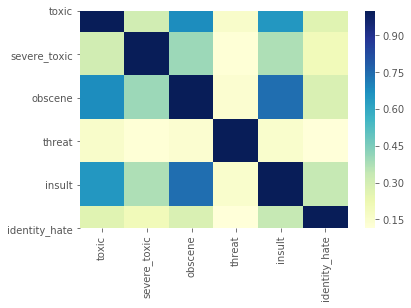

In [10]:
corr = train_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].corr()

# plot the heatmap
sns.heatmap(corr, 
            cmap="YlGnBu",
            xticklabels=corr.columns,
            yticklabels=corr.columns)

In [11]:
X_df = train_df["comment_text"].values
y_df = train_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
# X_test = test_df["comment_text"].values

In [12]:
# Getting the percentage, the numpy way
print(np.mean(y_df, axis=0) * 100)

[9.5844483  0.99955506 5.29482174 0.29955318 4.93636062 0.8804858 ]


In [13]:
# Total toxic comments - all class
num_of_classes = np.sum(y_df, axis=1)
atleast_one = num_of_classes[num_of_classes > 0]
print("Percentage of comments belonging to atleast one group", atleast_one.shape[0]*100/y_df.shape[0])

Percentage of comments belonging to atleast one group 10.167887648758233


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(127656,) (127656, 6)
(31915,) (31915, 6)


In [16]:
# Checking the distribution after split
print(np.mean(y_train, axis=0) * 100)
print(np.mean(y_test, axis=0) * 100)

[9.63213637 1.00582816 5.31114871 0.29924171 4.96803911 0.89537507]
[9.39370202 0.97446342 5.2295159  0.300799   4.80965063 0.8209306 ]


In [17]:
# Total toxic comments - all class
num_of_classes = np.sum(y_train, axis=1)
atleast_one = num_of_classes[num_of_classes > 0]
print("Train =>  Percentage of comments belonging to atleast one group", atleast_one.shape[0]*100/y_train.shape[0])

num_of_classes = np.sum(y_test, axis=1)
atleast_one = num_of_classes[num_of_classes > 0]
print("Train =>  Percentage of comments belonging to atleast one group", atleast_one.shape[0]*100/y_test.shape[0])

Train =>  Percentage of comments belonging to atleast one group 10.211035909005453
Train =>  Percentage of comments belonging to atleast one group 9.995300015666615


In [18]:
max_features = 20000  # number of words we want to keep
maxlen = 100  # max length of the comments in the model
batch_size = 64  # batch size for the model
embedding_dims = 20  # dimension of the hidden variable, i.e. the embedding dimension

In [47]:
# Not sure what length of comments means. Is it the number of words or characters?
# What is embedding dimension

In [49]:
# Text data must be encoded as numbers to be used as input or output for machine learning and deep learning models.

In [19]:
tok = Tokenizer(num_words=max_features)
# tok.fit_on_texts(list(X_train) + list(X_test))
tok.fit_on_texts(X_train)
x_train = tok.texts_to_sequences(X_train)
x_test = tok.texts_to_sequences(X_test)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Average train sequence length: {}'.format(np.mean(list(map(len, x_train)), dtype=int)))
print('Average test sequence length: {}'.format(np.mean(list(map(len, x_test)), dtype=int)))

127656 train sequences
31915 test sequences
Average train sequence length: 65
Average test sequence length: 64


In [60]:
# Can we use fit_on_texts on the testing data. Are we not tweaking the results there?

In [20]:
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (127656, 100)
x_test shape: (31915, 100)


In [21]:
input     = Input((maxlen,))
embedding = Embedding(max_features, embedding_dims, input_length=maxlen, 
                        embeddings_initializer="uniform")(input)
hidden    = GlobalMaxPooling1D()(embedding)
output    = Dense(6, activation='sigmoid')(hidden)
model = Model(inputs=input, outputs=output)

model.compile(loss='binary_crossentropy',
              optimizer=Adam(0.01),
              metrics=['accuracy'])

In [22]:
hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=10,  validation_data=(x_test, y_test))

/home/work/anaconda3/envs/ml_py3.7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 10s 77us/step - loss: 0.0725 - accuracy: 0.9771 - val_loss: 0.0544 - val_accuracy: 0.9809
Epoch 2/10
127656/127656 [==============================] - 7s 58us/step - loss: 0.0524 - accuracy: 0.9811 - val_loss: 0.0532 - val_accuracy: 0.9810
Epoch 3/10
127656/127656 [==============================] - 7s 53us/step - loss: 0.0489 - accuracy: 0.9820 - val_loss: 0.0521 - val_accuracy: 0.9812
Epoch 4/10
127656/127656 [==============================] - 7s 53us/step - loss: 0.0463 - accuracy: 0.9827 - val_loss: 0.0513 - val_accuracy: 0.9815
Epoch 5/10
127656/127656 [==============================] - 7s 57us/step - loss: 0.0448 - accuracy: 0.9832 - val_loss: 0.0517 - val_accuracy: 0.9815
Epoch 6/10
127656/127656 [==============================] - 7s 52us/step - loss: 0.0435 - accuracy: 0.9834 - val_loss: 0.0530 - val_accuracy: 0.9811
Epoch 7/10
127656/127656 [============================

In [23]:
training_score = model.evaluate(np.array(x_train),np.array(y_train))
print('Training')
print(model.metrics_names) 
print(training_score)


127656/127656 [==============================] - 2s 17us/step
Training
['loss', 'accuracy']
[0.03655799224722721, 0.9857820868492126]


In [24]:
testing_score = model.evaluate(np.array(x_test),np.array(y_test))
print('Training')
print(model.metrics_names) 
print(testing_score)

31915/31915 [==============================] - 1s 19us/step
Training
['loss', 'accuracy']
[0.05633315006770006, 0.981049120426178]


In [30]:
print(hist.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


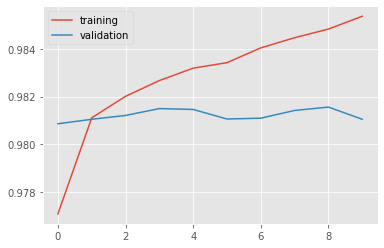

In [31]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [38]:
a = model.predict(x_test[:2])
print(a)
print(np.round(a))

[[9.9938560e-01 1.1546931e-01 9.8758119e-01 1.5202165e-04 9.7094429e-01
  2.1951824e-02]
 [9.8922849e-04 2.2947788e-06 3.1004249e-05 1.1417759e-05 1.3829641e-04
  5.9363174e-05]]
[[1. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [37]:
print(y_test[:2])

[[1 0 1 0 1 0]
 [0 0 0 0 0 0]]


In [67]:
# Prediction
y_predict = model.predict(x_test)
y_pred = np.round(y_predict)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = multilabel_confusion_matrix(y_test, y_pred)
# print(cm)

i = 0

for each in ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]:
    print(each)
    print(cm[i])
    i = i + 1


toxic
[[28515   402]
 [  911  2087]]
severe_toxic
[[31574    30]
 [  273    38]]
obscene
[[30141   105]
 [  666  1003]]
threat
[[31809    10]
 [   82    14]]
insult
[[30098   282]
 [  596   939]]
identity_hate
[[31579    74]
 [  198    64]]
